In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [2]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
# Bỏ cột id
df = df.drop(columns=["id"])

In [4]:
# Xử lý giá trị thiếu trong cột bmi
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

In [5]:
# Mã hóa các cột categorical
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [6]:
# Tách đặc trưng và nhãn
X = df.drop(columns=["stroke"]).values
y = df["stroke"].values

In [7]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [8]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Tính trọng số lớp
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

In [10]:
# Xây dựng và huấn luyện mô hình Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

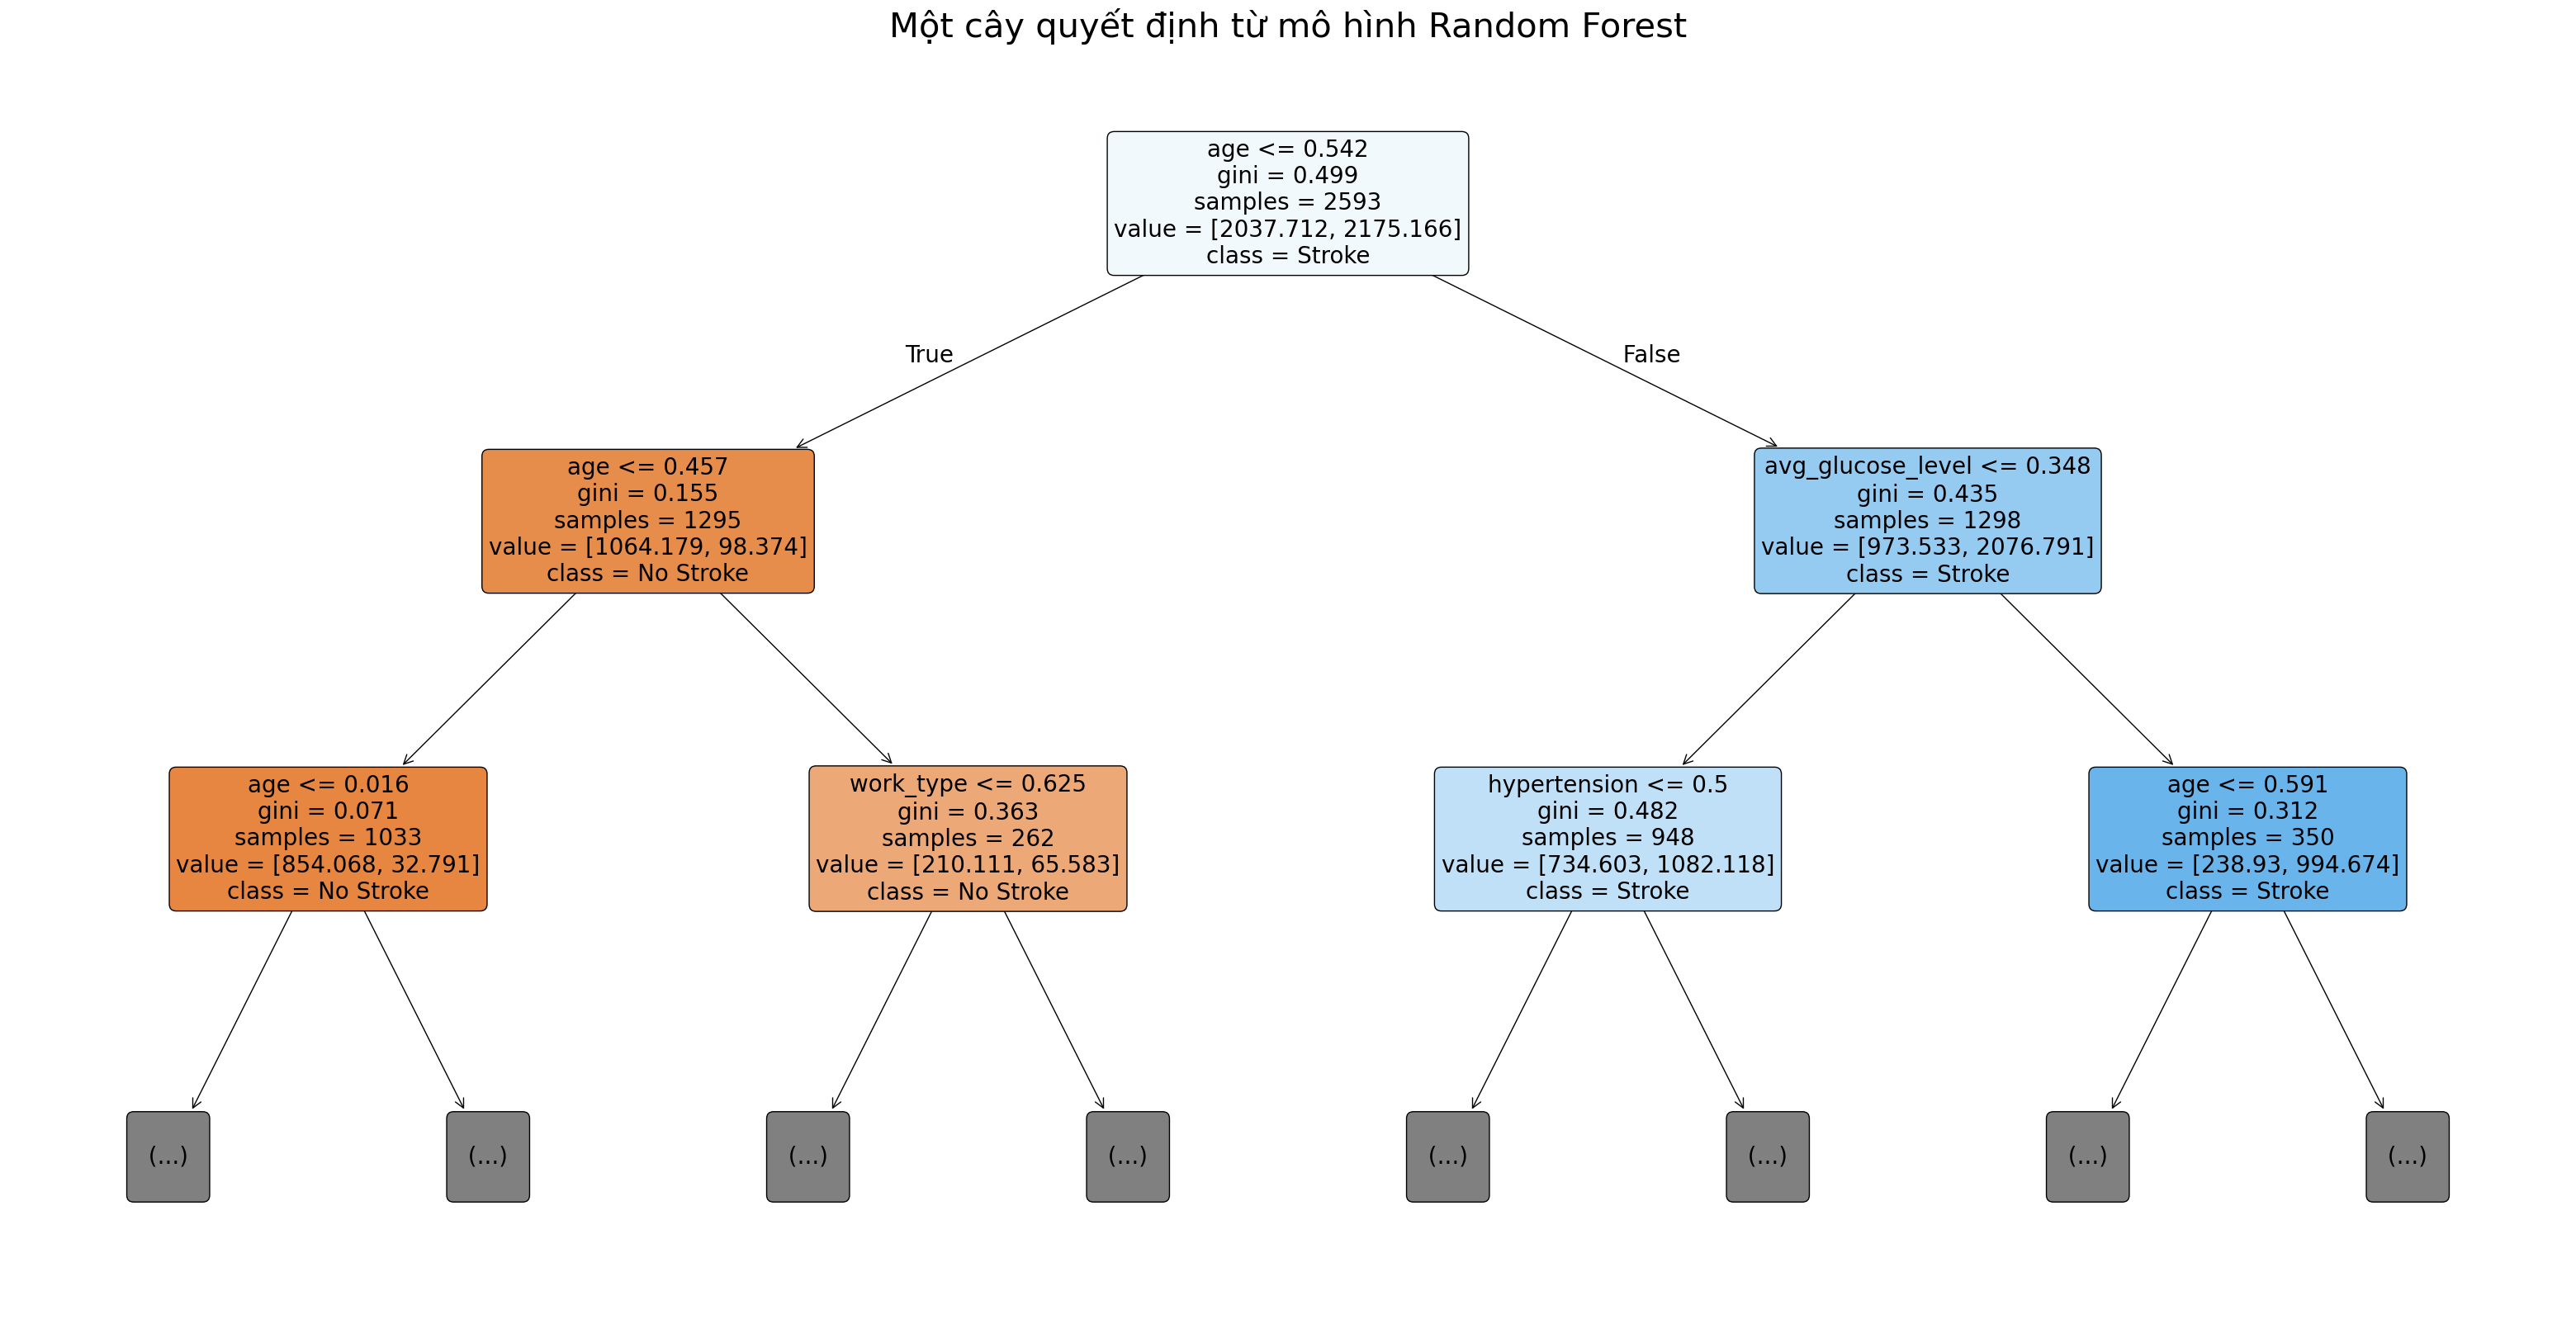

In [11]:
feature_names = df.drop(columns=["stroke"]).columns.tolist()
plt.figure(figsize=(40, 20))
plot_tree(model.estimators_[0],
          feature_names=feature_names,
          class_names=["No Stroke", "Stroke"],
          filled=True,
          rounded=True,
          max_depth=2,
          fontsize=20) 
plt.title("Một cây quyết định từ mô hình Random Forest", fontsize=30)
plt.show()


In [12]:
# Đánh giá mô hình
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Độ chính xác của mô hình: {accuracy:.2f}")

Độ chính xác của mô hình: 0.94


In [13]:
# Mẫu dữ liệu mới: 10 đặc trưng giữ nguyên giá trị gốc
dotquy_original =np.array([[0	,27.0,	0,	1,	1,	2,	1,	228.69,	25.600000,	1	]])  # Giá trị gốc
dotquy = scaler.transform(dotquy_original)  # Chuẩn hóa cho dự đoán
y_dotquy = model.predict(dotquy)
y_dotquy_proba = model.predict_proba(dotquy)[0]

# Dự đoán và đưa ra cảnh báo
print(f"Dự đoán: {y_dotquy[0]} (0 = không đột quỵ, 1 = có đột quỵ)")
print(f"Xác suất: Không đột quỵ = {y_dotquy_proba[0]:.2f}, Có đột quỵ = {y_dotquy_proba[1]:.2f}")

# Cảnh báo sớm
if y_dotquy[0] == 1:
    print("Cảnh báo khẩn cấp: Nguy cơ đột quỵ cao (xác suất: {:.2f}). Cần thăm khám ngay lập tức.".format(y_dotquy_proba[1]))
elif y_dotquy_proba[1] > 0.3:
    print("Cảnh báo: Có nguy cơ tiềm ẩn (xác suất bị đột quỵ: {:.2f}). Hãy kiểm tra sức khỏe định kỳ.".format(y_dotquy_proba[1]))

# Đề xuất biện pháp phòng ngừa (dùng giá trị gốc)
age = dotquy_original[0][1]  # Tuổi từ giá trị gốc
glucose = dotquy_original[0][7]  # Mức glucose từ giá trị gốc
hypertension = dotquy_original[0][2]  # Tăng huyết áp từ giá trị gốc
if age > 50 or glucose > 150 or hypertension == 1:
    print("Biện pháp phòng ngừa:")
    if age > 50:
        print("- Giảm căng thẳng, tập thể dục nhẹ nhàng (30 phút/ngày).")
    if glucose > 150:
        print("- Kiểm soát đường huyết, giảm đồ ngọt, tham khảo bác sĩ về chế độ ăn.")
    if hypertension == 1:
        print("- Theo dõi huyết áp thường xuyên, dùng thuốc theo chỉ định bác sĩ.")

Dự đoán: 0 (0 = không đột quỵ, 1 = có đột quỵ)
Xác suất: Không đột quỵ = 0.99, Có đột quỵ = 0.01
Biện pháp phòng ngừa:
- Kiểm soát đường huyết, giảm đồ ngọt, tham khảo bác sĩ về chế độ ăn.
